In [1]:
%matplotlib inline
import argparse
import glob
import logging
import os
import pickle
import random
import re
import csv
from typing import Dict, List, Tuple
import numpy as np
from scipy import stats
from termcolor import colored
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from model.bert_util import *

In [2]:
sns.set_context("paper", font_scale=1.25)
matplotlib.rcParams['figure.dpi']= 150

In [3]:
influence_dir = "influence_logs/candidate_tagger_outputs_synth/"
# influence_dir = "influence_logs/candidate_coord_tuned_tagger_synth_IT/"
# influence_dir = "influence_logs/candidate_coord_tuned_tagger_synth_ET/"
# influence_dir = "influence_logs/candidate_tagger_outputs_synth_no_spur/"

# influence_dir = "influence_logs/candidate_tagger_outputs_msgs/"
# influence_dir = "influence_logs/candidate_coord_tuned_tagger_msgs_IT/"
# influence_dir = "influence_logs/candidate_coord_tuned_tagger_msgs_ET/"
num_recorded_epoch = 9 # or 9 or 17 based on alternate_interval 50 or 25
num_test_ex_interpreted = 40

In [4]:
if 'synth' in influence_dir:
    processor = SynthProcessor()
    label_list = processor.get_labels()
    num_labels = len(label_list)
    if 'no_spur' in influence_dir:
        data_dir = "synthetic_outputs/no_spur/"
    else:
        data_dir = "synthetic_outputs/"
elif 'msgs' in influence_dir:
    processor = MSGSProcessor()
    label_list = processor.get_labels()
    num_labels = len(label_list)
    data_dir = "msgs_outputs/"
train_examples = processor.get_train_examples(data_dir)
test_examples = processor.get_train_examples(data_dir)

### Influence score distribution for phenomenon-sharing training examples

In [5]:
# we investigate two kinds of same-label-as-test training examples, are same-spur more influential than diff-spur which does not make sense?
def plot_score_distribution_spur(test_idx):
    influence = pickle.load(open(os.path.join(influence_dir, f"influence_test_idx_{test_idx}.pkl"), "rb"))
    influence = influence[-1]
    # influence = np.mean(influence, axis=0)
    target_influence = []
    non_target_influence = []

    for te_idx, te in enumerate(test_examples):
        if te_idx != test_idx:
            continue
        test_note = te.note[1]

        inf_sorted_idx = list(np.argsort(influence))
        inf_sorted_idx.reverse()
        for _i, isi in enumerate(inf_sorted_idx):
            if train_examples[isi].label != te.label: # important: only look at same label example
                continue
            if train_examples[isi].note[1] == test_note:
                target_influence.append(influence[isi])
            else:
                non_target_influence.append(influence[isi])

        print("probing example gold label:", f"[{te.label}]")
        print("probing example spurious attrib:", test_note)
        break
        
    print("avg influence score diff:", np.mean(target_influence) - np.mean(non_target_influence))
    print(stats.ttest_ind(target_influence, non_target_influence, equal_var=False))

    ax = sns.distplot(non_target_influence, label='same class label\ndifferent spurious prefix', kde=True)
    ax = sns.distplot(target_influence, label='same class label\nsame spurious prefix', kde=True)
    plt.axvline(x=np.mean(non_target_influence), color='steelblue', linestyle='--')
    plt.axvline(x=np.mean(target_influence), color='orange', linestyle='--')
#     plt.title(f"Probing example #{test_idx}")
    plt.xlabel("Training example influence score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

probing example gold label: [0]
probing example spurious attrib: 0
avg influence score diff: 0.1518668460404431
Ttest_indResult(statistic=5.586870367089999, pvalue=2.978679532608953e-07)


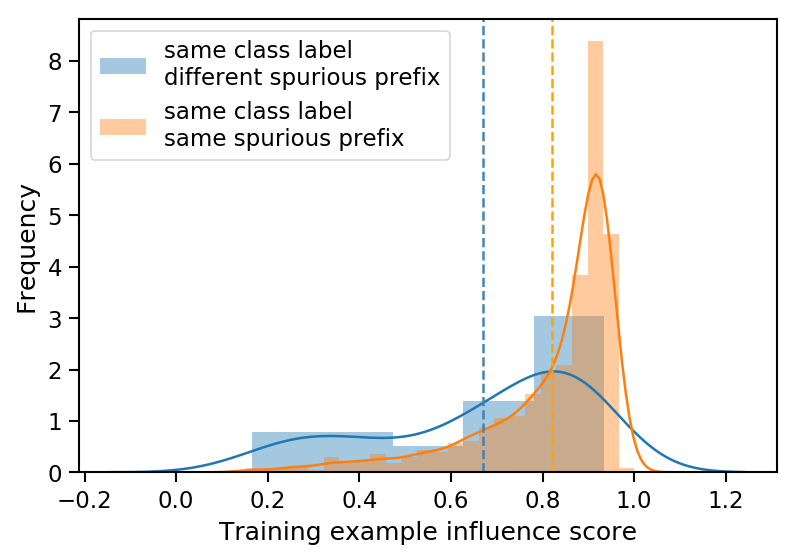

In [6]:
plot_score_distribution_spur(2)

In [7]:
def plot_spur_influence_diff(test_idx_lb, test_idx_ub, epoch_i=-1):
    diff_list = []
    for test_idx in range(test_idx_lb, test_idx_ub):
        influence = pickle.load(open(f"{influence_dir}/influence_test_idx_{test_idx}.pkl", "rb"))
        influence = influence[epoch_i]
        # influence = np.mean(influence, axis=0)
        target_influence = []
        non_target_influence = []

        for te_idx, te in enumerate(test_examples):
            if te_idx != test_idx:
                continue
            test_note = te.note[1]

            inf_sorted_idx = list(np.argsort(influence))
            inf_sorted_idx.reverse()
            for _i, isi in enumerate(inf_sorted_idx):
                if train_examples[isi].label != te.label: # important: only look at same label example
                    continue
                if train_examples[isi].note[1] == test_note:
                    target_influence.append(influence[isi])
                else:
                    non_target_influence.append(influence[isi])

            diff_list.append(np.mean(target_influence) - np.mean(non_target_influence))
            break
    ax = sns.distplot(diff_list, label='same vs opposite spurious attrib examples influence difference', kde=False)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel("influence score diff")
    plt.title(f"Test example {test_idx_lb} to {test_idx_ub}: {np.mean(diff_list)}")
    plt.show()
    return np.mean(diff_list)

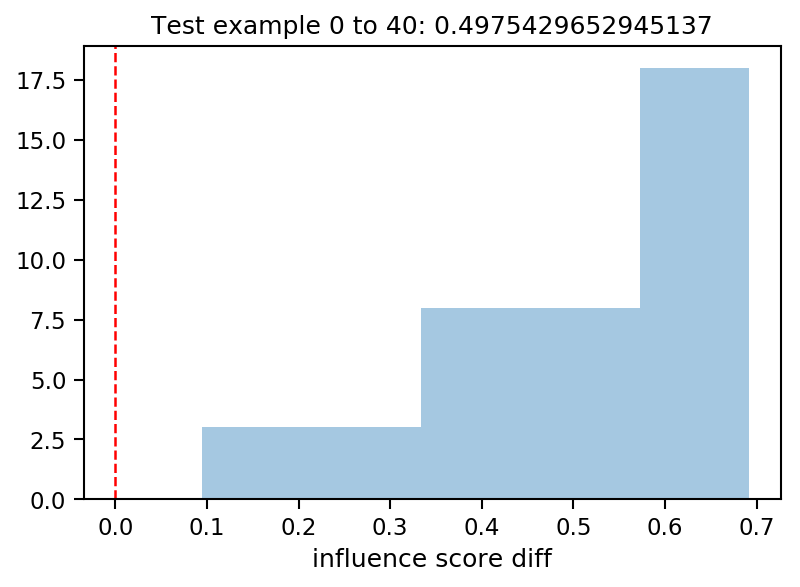

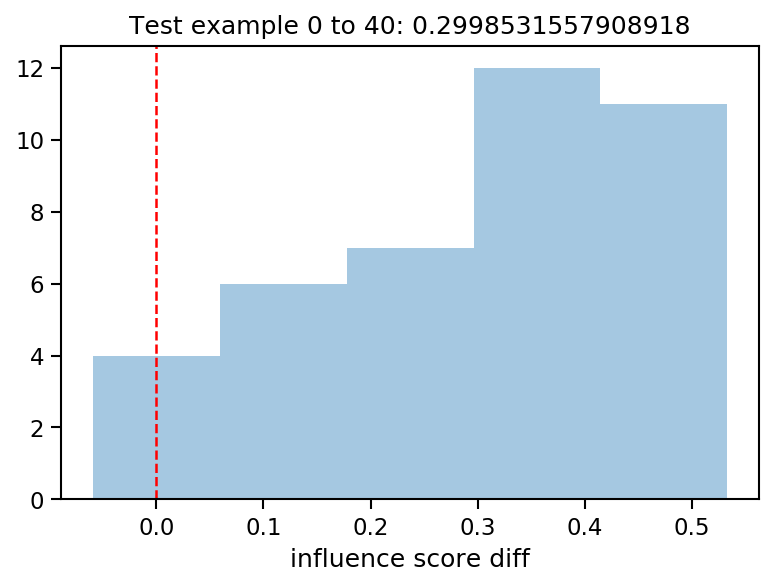

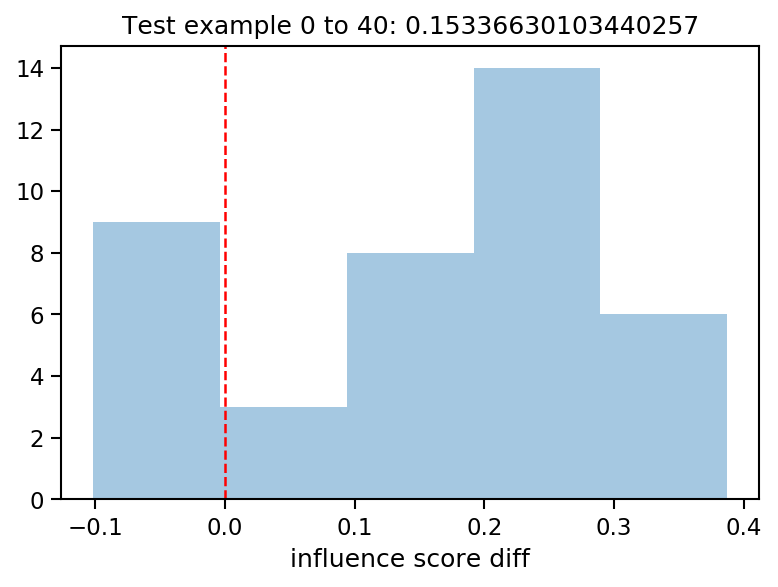

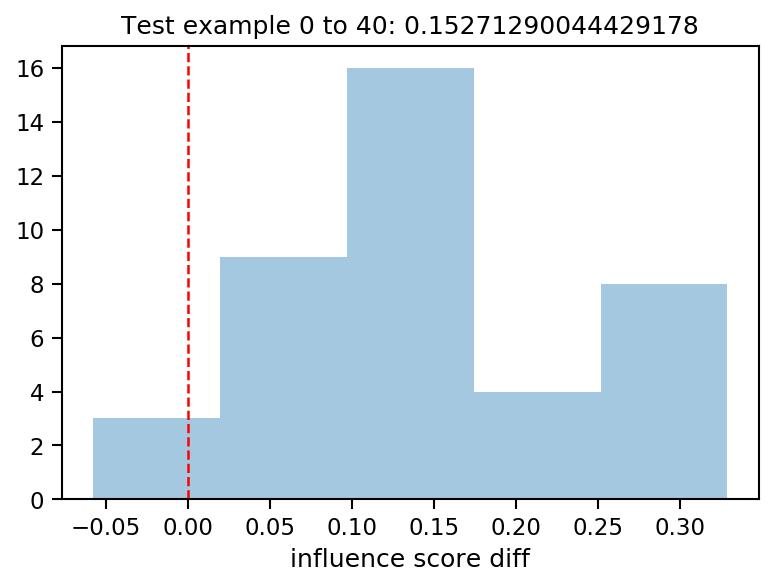

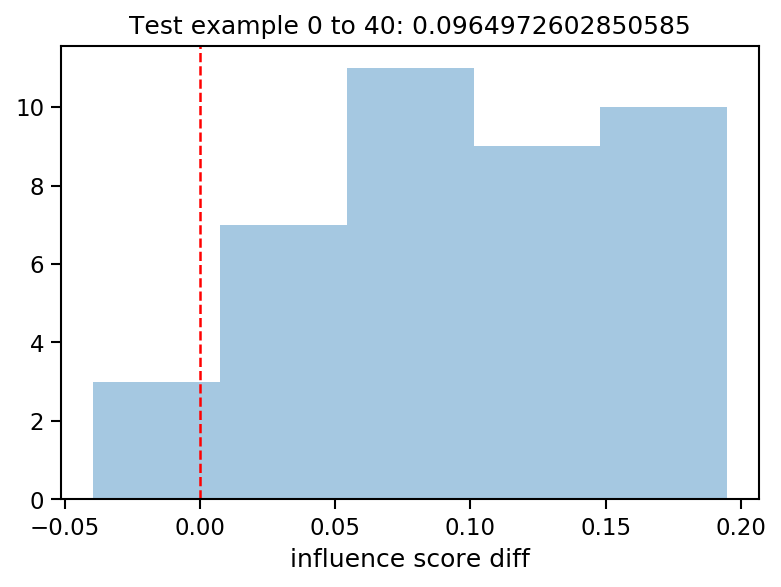

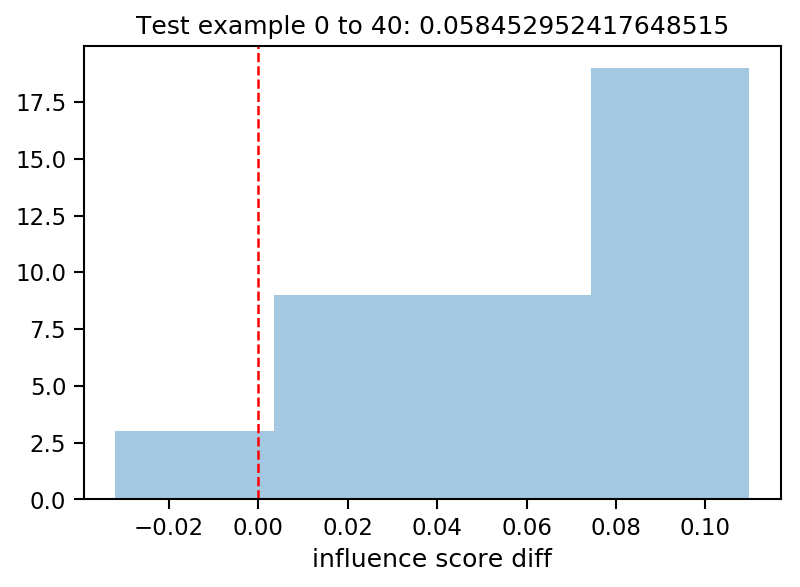

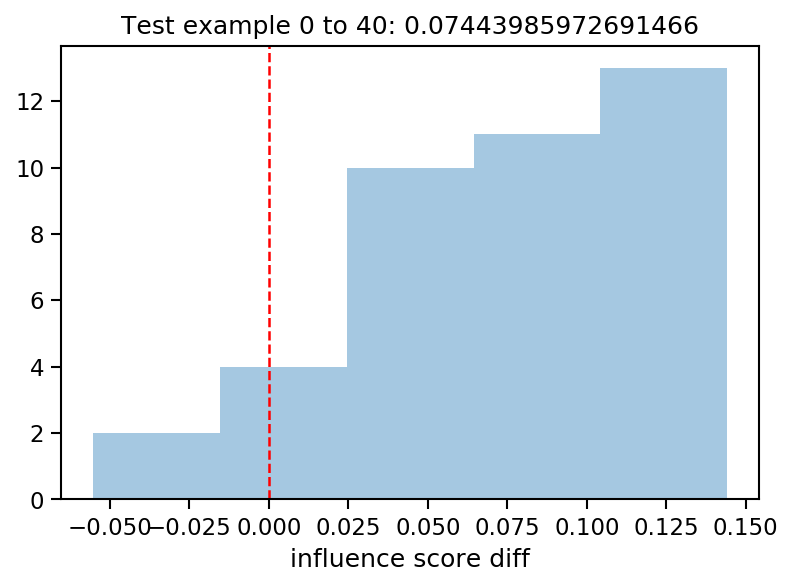

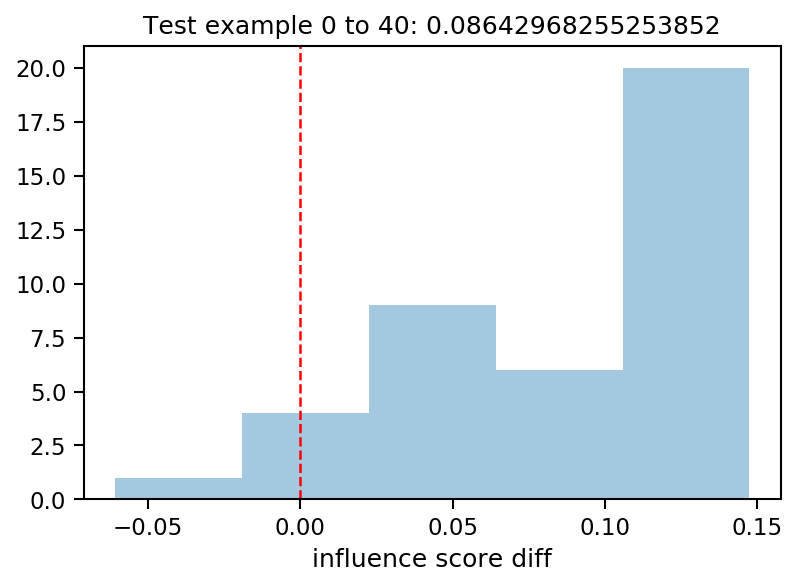

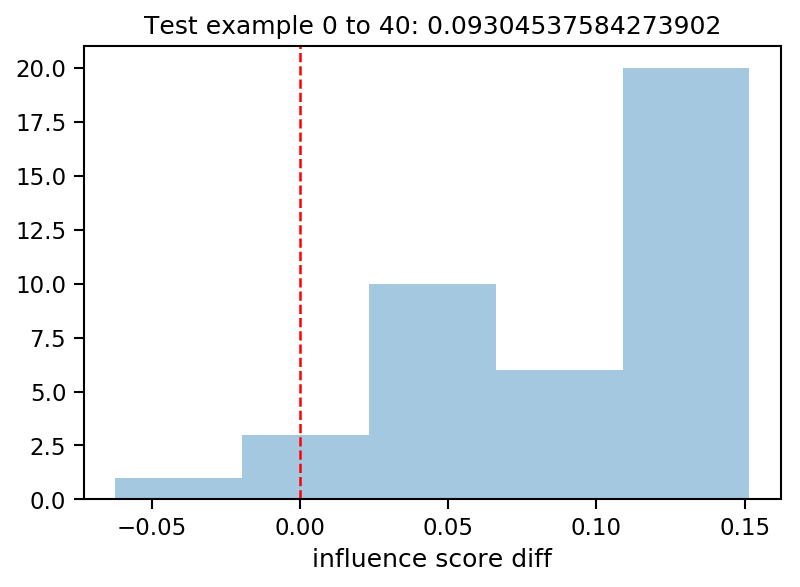

[0.4975429652945137, 0.2998531557908918, 0.15336630103440257, 0.15271290044429178, 0.0964972602850585, 0.058452952417648515, 0.07443985972691466, 0.08642968255253852, 0.09304537584273902]


In [8]:
cig_list = []
for epoch_i in range(num_recorded_epoch):
    cig_list.append(plot_spur_influence_diff(0, num_test_ex_interpreted, epoch_i))
print(cig_list)

In [9]:
synth_vanilla = [0.4975429652945137, 0.2998531557908918, 0.15336630103440257, 0.15271290044429178, 0.0964972602850585, 0.058452952417648515, 0.07443985972691466, 0.08642968255253852, 0.09304537584273902, 0.09339821375934061]
synth_it = [0.37668993265359096, 0.005748083205134774, 0.11506404227389574, -0.0006021879723862456, 0.38655328320706434, 0.02459651411790347, 0.07731358367190869, 0.017950511849519825, 0.034878942179899994]
synth_no_spur = [0.011723374013355142, 0.00669087510215145, 0.001999017016462017, 0.01592732274750705, 0.021378182869431505, 0.022412186989448614, 0.020981065111683198, 0.019121402820535326, 0.01896548323814769, 0.018980626292370573]

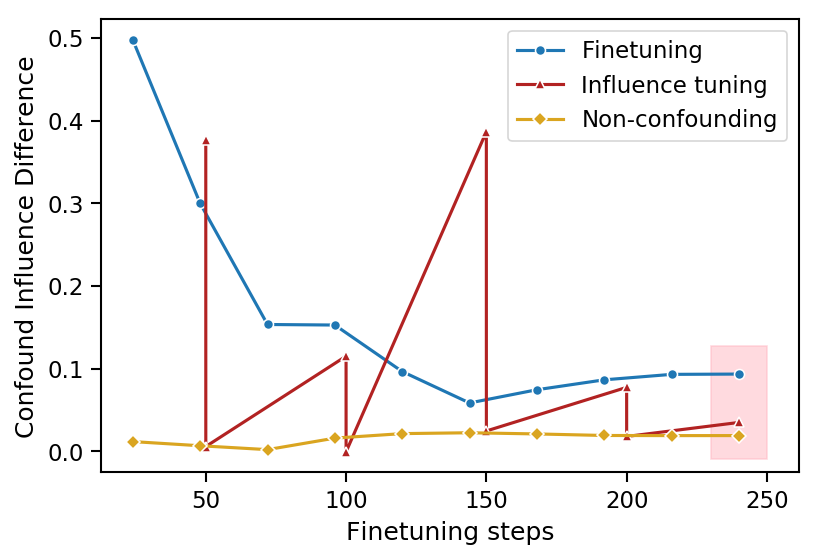

In [34]:
sns.lineplot(x=list(range(24, 241, 24)), y=synth_vanilla, label='Finetuning', lw=1.5, marker='o')
sns.lineplot(x=[50, 50.01, 100, 100.01, 150, 150.01, 200, 200.01, 240], y=synth_it, label='Influence tuning', lw=1.5, marker='^', color='firebrick')
sns.lineplot(x=list(range(24, 241, 24)), y=synth_no_spur, label='Non-confounding', lw=1.5, marker='D', color='goldenrod')

plt.axvspan(230, 250, color='lightpink', alpha=0.5, ymin=0.03, ymax=0.28)
plt.legend()
plt.xlabel("Finetuning steps")
plt.ylabel("Confound Influence Difference")
plt.show()

In [96]:
msgs_vanilla = [0.12989292064129948, 0.01814659940325634, 0.03223720160959306]
msgs_it = [0.0914170663256632, -0.03777362833290374, -0.0010099734873894428, -0.027341899162870054, 0.023341182742472398, 0.0008336633511576624, 9.855553217049396e-05, -5.581208158446926e-05, -6.654211645096553e-05]
msgs_et = [0.15545962051191636, -0.004088047418201573, 0.007742498262293418, -0.014036011660281508, 0.05894040053803147, 0.007092869325961898, 0.0015689429944274497, 0.0010299600032663142, 0.000888579186338459, 0.0006587321031395116, 0.0005041386710170265, 0.0004919521128431082, 0.0004680754022099914, 0.0004192205476465899, 0.0004261217870945522, 0.00039397554805917776, 0.0003926438915492603]

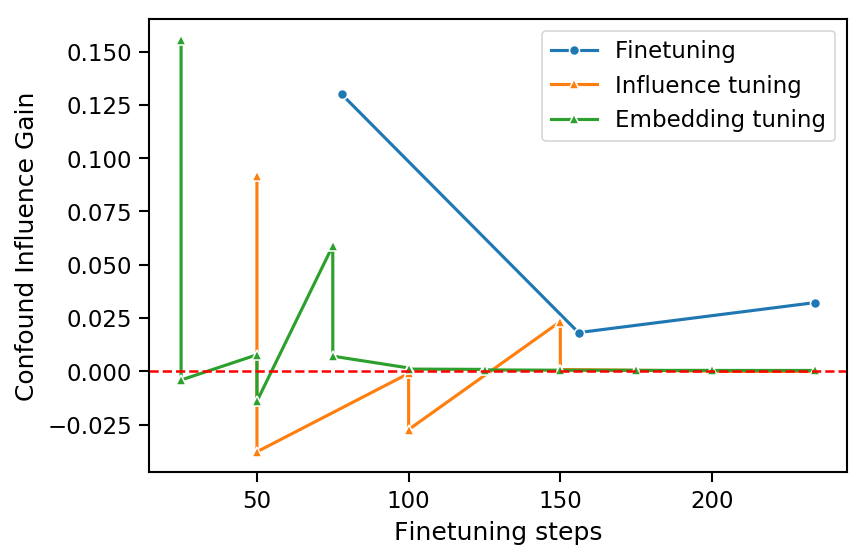

In [97]:
sns.lineplot(x=list(range(78, 235, 78)), y=msgs_vanilla, label='Finetuning', lw=1.5, marker='o')
sns.lineplot(x=[50, 50.01, 100, 100.01, 150, 150.01, 200, 200.01, 234], y=msgs_it, label='Influence tuning', lw=1.5, marker='^')
sns.lineplot(x=[25, 25.01, 50, 50.01, 75, 75.01, 100, 100.01, 125, 125.01, 150, 150.01, 175, 175.01, 200, 200.01, 234], y=msgs_et, label='Embedding tuning', lw=1.5, marker='^')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.xlabel("Finetuning steps")
plt.ylabel("Confound Influence Difference")
plt.show()

## Quantitative results

In [2]:
synth_vanilla = [77.6, 75.2, 76.6, 76.0, 74.6]
synth_dann = [79.8, 80.0, 78.4, 78.0, 76.0]
synth_no_spur = [83.8, 85.0, 84.8, 85.0, 86.2]
synth_it = [79.6, 82.6, 77.4, 80.8, 82.0]
synth_et = [83.0, 84.8, 80.8, 82.8, 79.6]
print(np.mean(synth_vanilla), np.mean(synth_dann), np.mean(synth_no_spur), np.mean(synth_it), np.mean(synth_et))

print(stats.ttest_ind(synth_vanilla, synth_dann))
print(stats.ttest_ind(synth_vanilla, synth_no_spur))
print(stats.ttest_ind(synth_vanilla, synth_it))
print(stats.ttest_ind(synth_vanilla, synth_et))

76.0 78.44000000000001 84.96000000000001 80.47999999999999 82.2
Ttest_indResult(statistic=-2.73210416703659, pvalue=0.025761830306679553)
Ttest_indResult(statistic=-13.799320721394833, pvalue=7.34500702304317e-07)
Ttest_indResult(statistic=-4.206248290656602, pvalue=0.0029710489301352856)
Ttest_indResult(statistic=-5.911468053322674, pvalue=0.00035710287707170735)


In [3]:
msgs_vanilla = [71.37333333333333, 82.73333333333334, 85.14666666666667, 68.49333333333333, 68.91333333333334]
msgs_dann = [82.38666666666666, 68.14, 91.57333333333333, 84.79333333333333, 90.15333333333333]
msgs_it = [84.26666666928213, 91.71333333069924, 91.59999999974389, 92.0266666696989, 81.51999999972759]
msgs_et = [90.47333333001006, 91.88666667032521, 92.51333332940703, 88.82666667050216, 73.54666666942649]
print(np.mean(msgs_vanilla), np.mean(msgs_dann), np.mean(msgs_it), np.mean(msgs_et))

print(stats.ttest_ind(msgs_vanilla, msgs_dann))
print(stats.ttest_ind(msgs_vanilla, msgs_it))
print(stats.ttest_ind(msgs_vanilla, msgs_et))

75.33200000000001 83.40933333333332 88.22533333383035 87.44933333393419
Ttest_indResult(statistic=-1.4710500609530095, pvalue=0.17948453591048383)
Ttest_indResult(statistic=-3.067311028530629, pvalue=0.015410651517672472)
Ttest_indResult(statistic=-2.4128615857073474, pvalue=0.042318818173362985)
